In [2]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time
import scipy.optimize as opt
from sklearn.decomposition import FastICA, PCA

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy
%matplotlib inline
import librosa
import librosa.display

In [100]:
N=6
def DFT_mat(L):
    m, k = np.meshgrid(np.arange(L), np.arange(L))
    Z = np.exp(-1j*2*np.pi*m*k/L)/np.sqrt(L)
    return Z
def DFT_mat_Hann(L):
    return DFT_mat(L)@np.diag(np.hanning(L))

print(DFT_mat(2)/scipy.linalg.dft(2))
print(scipy.linalg.dft(2))

print(np.allclose(scipy.linalg.dft(512)/np.sqrt(512), DFT_mat(512)))
print(np.allclose(DFT_mat(512).conj().T, np.linalg.inv(DFT_mat(512))))
A = DFT_mat_Hann(N)
print(A.shape)
def A_mat(Z_DFT,N,L,S):
    A = np.pad(Z_DFT, [(0, 0), (0, N-L)], 'constant')
    for i in np.arange(0,N-L+1,int(L/2)):
        if i == 0:
            continue
        A=np.concatenate((A,np.pad(Z_DFT, [(0, 0), (i, N-L-i)], 'constant')),axis=0) 
    return A


[[0.70710678+0.j 0.70710678+0.j]
 [0.70710678+0.j 0.70710678-0.j]]
[[ 1.+0.0000000e+00j  1.+0.0000000e+00j]
 [ 1.+0.0000000e+00j -1.-1.2246468e-16j]]
True
True
(6, 6)


In [287]:
Atest = np.array([[0,1,0],[0,0,0],[1,0,0]])
y = np.array([1,2,3])
print(Atest)
print(Atest @ y)
Atest_sparse = scipy.sparse.csr_matrix(Atest)
print(Atest_sparse)
print(Atest_sparse @ y)

[[0 1 0]
 [0 0 0]
 [1 0 0]]
[2 0 1]
  (0, 1)	1
  (2, 0)	1
[2 0 1]


In [122]:
L = 64
S = 32
N = 256
A_STFT=A_mat(DFT_mat(L),N,L,S)
A_STFT_Hann=A_mat(DFT_mat_Hann(L),N,L,S)
#np.block([[T,T],[np.zeros((2,1)),T,np.zeros((2,1))]])
#np.block([A,A])

(6, 6)


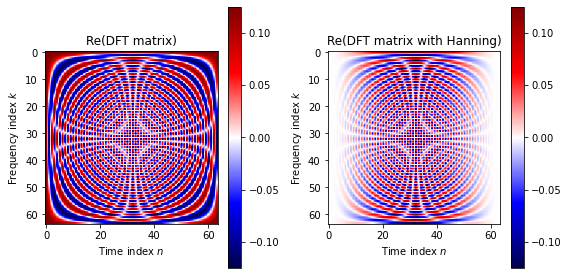

In [167]:
print(A.shape)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Re(DFT matrix)')
plt.imshow(np.real(DFT_mat(L)), cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Re(DFT matrix with Hanning)')
plt.imshow(np.real(DFT_mat_Hann(L)), cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()
plt.tight_layout()


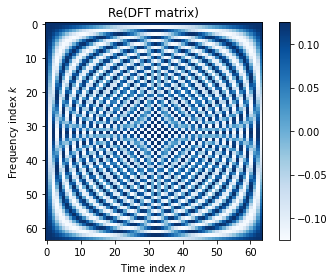

In [162]:
plt.title('Re(DFT matrix)')
plt.imshow(np.real(DFT_mat(64)),cmap='Blues', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

In [102]:
DFT_mat(1024)[512,500]

(0.03125+5.022135092618177e-15j)

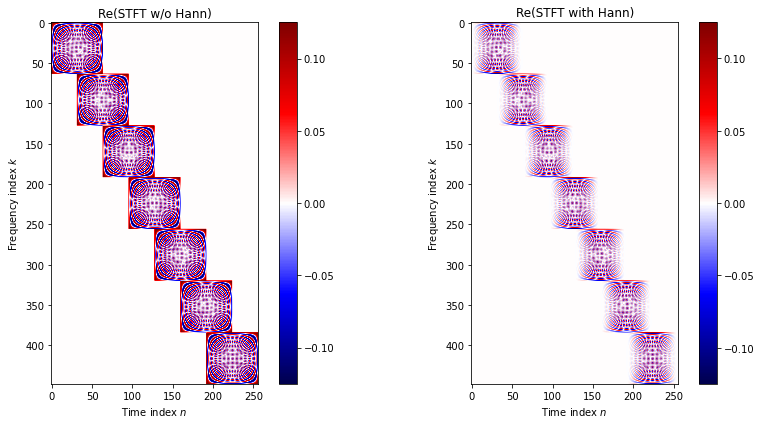

In [130]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Re(STFT w/o Hann)')
plt.imshow(np.real(A_STFT),  cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Re(STFT with Hann)')
plt.imshow(np.real(A_STFT_Hann),  cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()
plt.tight_layout()

(7936,)
(256, 31)


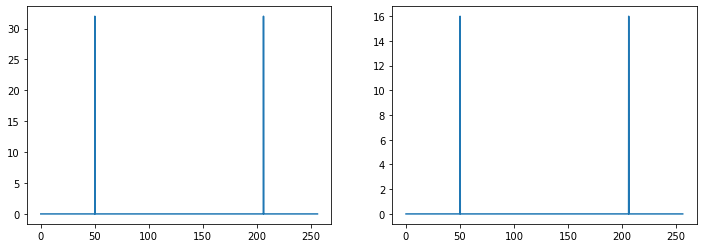

<Figure size 864x288 with 0 Axes>

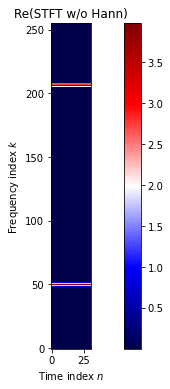

In [253]:
## Signal Test
Ns = 4096
fs = 256   # Hz
time = np.linspace(1/fs,Ns/fs,num=Ns)
freq = np.linspace(fs/Ns,fs,num=Ns)

s = np.sin(2*np.pi*50*time)
#s = signal.sawtooth(time * 19)
L = 256
S = 0.5*L
N = Ns


S_DFT = abs(DFT_mat(Ns)@s)
S_DFT_Hann = abs(DFT_mat_Hann(Ns)@s)
S_STFT = A_mat(DFT_mat_Hann(L),N,L,S)@s

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(freq,S_DFT)
plt.subplot(1,2,2)
plt.plot(freq,S_DFT_Hann)
plt.figure(figsize=(12, 4))


print(S_STFT.shape)
S_STFT_plot = np.reshape(S_STFT,(int(2*N/L)-1,-1)).T
print(S_STFT_plot.shape)
time_tf = np.linspace(1/fs,Ns/fs,num=len(S_STFT_plot[0,:]))
freq_tf = np.linspace(fs/L,fs,num=L)


plt.figure(figsize=(12, 6))

plt.title('Re(STFT w/o Hann)')
plt.imshow(abs(S_STFT_plot),  origin='lower',cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()



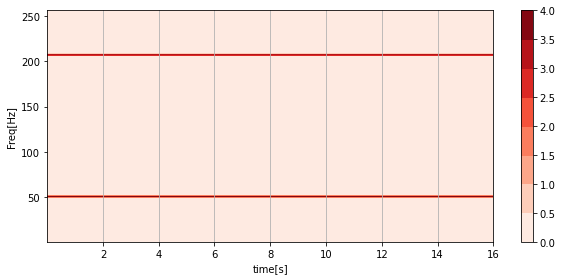

In [256]:
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(time_tf, freq_tf, abs(S_STFT_plot),cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('time[s]')
plt.ylabel('Freq[Hz]')
plt.tight_layout()
plt.grid(True,axis='x')

In [80]:
## Voice Test

fs_true, HSdata = sio.wavfile.read('../../SeeCorner/VoiceRecords/AugRecord.wav')
_, JPdata = sio.wavfile.read('../../SeeCorner/VoiceRecords/JuneRecord.wav')

Ns_true = 2**16
#data_true = HSdata[130000:130000+Ns_true,0]
data_true = HSdata[170000:170000+Ns_true,0]


factor_ADC=8
fs = fs_true/factor_ADC
data = data_true[::factor_ADC]

Ns = len(data)
L = 512
S = 0.25*L
print('original Ns:',Ns_true)
print('sampled Ns:',Ns)
print('sampling f:',fs)
#S_DFT = abs(DFT_mat(Ns)@s)
#S_DFT_Hann = abs(DFT_mat_Hann(Ns)@s)

time = np.linspace(1/fs,Ns/fs,num=Ns)
#S = JPdata[:,0]

#Audio(data_true, rate=fs_true)
Audio(data, rate=fs)

original Ns: 65536
sampled Ns: 7915
sampling f: 5512.5


In [81]:
data_STFT = A_mat(DFT_mat_Hann(L),Ns,L,S)@data

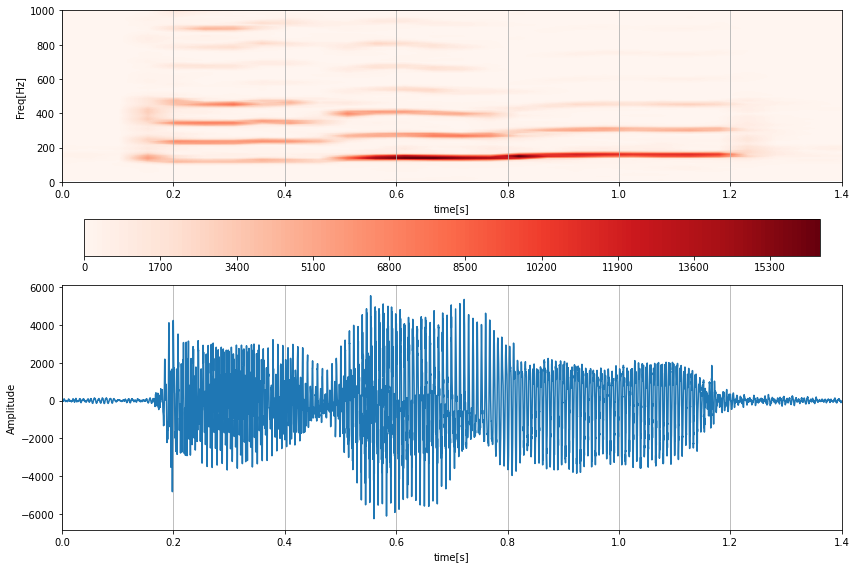

In [120]:
data_STFT_plot = np.reshape(data_STFT,(int(2*Ns/L)-1,-1)).T
time_tf = np.linspace(1/fs,Ns/fs,num=len(data_STFT_plot[0,:]))
freq_tf = np.linspace(fs/L,fs,num=L)

fig = plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
clev = np.arange(0,np.abs(data_STFT_plot).max(),100) #Adjust the .001 to get finer gradient
CS = plt.contourf(time_tf, freq_tf, np.abs(data_STFT_plot),clev,cmap='Reds')
plt.colorbar(CS,orientation='horizontal')
plt.xlabel('time[s]')
plt.ylabel('Freq[Hz]')
plt.xlim([0,1.4])
plt.ylim([0,1000])
plt.tight_layout()
plt.grid(True,axis='x')

plt.subplot(2,1,2)
plt.plot(time,data)
plt.xlabel('time[s]')
plt.ylabel('Amplitude')
plt.xlim([0,1.4])
plt.tight_layout()
plt.grid(True,axis='x')

In [279]:
print(data.shape)
print(time_tf.shape)
print(freq_tf.shape)

(65536,)
(31,)
(512,)


In [239]:
print(S_STFT_plot.shape)
print(time_tf.shape)
print(freq_tf.shape)

(256, 31)
(31,)
(256,)


In [ ]:
## P3 verification


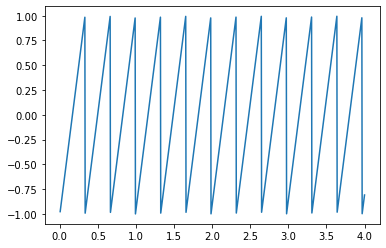

In [214]:
plt.plot(time,s)

In [178]:

2*N/L-

7.0

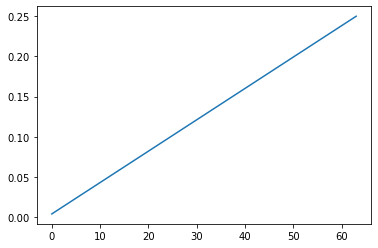

In [205]:
plt.plot(time)

In [84]:
L = 64
S = 32
N = 1024
T = ones((L,L))
A = np.pad(T, [(0, 0), (0, N-L)], 'constant')
for i in np.arange(0,N-L+1,int(L/2)):
    if i == 0:
        continue
    #print(i)
    #print(np.pad(T, [(0, 0), (i, N-L-i)], 'constant'))
    A=np.concatenate((A,np.pad(T, [(0, 0), (i, N-L-i)], 'constant')),axis=0)
print(A)
print(A.shape)


[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
(1984, 1024)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [79]:
np.concatenate((A,np.pad(T, [(0, 0), (i, N-L-i)], 'constant')),axis=0)

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]])

[0.        0.3454915 0.9045085 0.9045085 0.3454915 0.       ]
[[0.        0.        0.        0.        0.        0.       ]
 [0.        0.3454915 0.        0.        0.        0.       ]
 [0.        0.        0.9045085 0.        0.        0.       ]
 [0.        0.        0.        0.9045085 0.        0.       ]
 [0.        0.        0.        0.        0.3454915 0.       ]
 [0.        0.        0.        0.        0.        0.       ]]


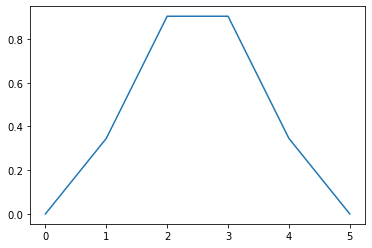

In [38]:
N = 6
print(np.hanning(N))
plt.plot(np.hanning(N))
print(np.diag(np.hanning(N)))

In [12]:
print(i)
print(j)
print(i*j)

[[0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]]
[[0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [4 4 4 4 4 4]
 [5 5 5 5 5 5]]
[[ 0  0  0  0  0  0]
 [ 0  1  2  3  4  5]
 [ 0  2  4  6  8 10]
 [ 0  3  6  9 12 15]
 [ 0  4  8 12 16 20]
 [ 0  5 10 15 20 25]]
